## Clustering analysis on pig movement models

The goal is to identify

1. Does the way in which pigs use non-crop resources differ between crop-using pigs an non-crop using pigs?
    - Only examine non-crop resources
    - For each model (1, 2, and 3) and study run a random forest in which the response variable is "crop user" and the predictor variables
    are the step-selection function response variables.
    - Examine the predictive accuracy of this model (I can't imagine it will be high) and explore the variable importance to understand
    whether any particular variables are distinguishing between crop and non-crop users.
2. Within pigs that use crops, are there different ways of using crops?
    - We know that our label of crop-users is a little weak, considering that the only criteria was thaty pigs were in crops at all.  However, pigs can use crops differently. So the next step is to determine whether pigs that use crops (within a study) use crops differently. 

In [98]:
from sklearn import cluster, datasets, mixture, ensemble, decomposition
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import yaml
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
plt.rcParams['figure.facecolor'] = "white"

In [99]:
# Load parameter files
with open("analysis_parameters.yml", 'r') as stream:
    try:
        params = yaml.load(stream)
    except yaml.YAMLError as exc:
        print(exc)
ctypes = params['croptypes']

In [100]:
# Load in the model parameters
modparams = []

for i in range(1, 4):
    modparams.append(pd.read_csv("../results/effect_size_data/model{0}allparams.csv".format(i)))

In [102]:
# Make a crop user dictionary to link to
mod1main = pd.read_csv("../results/effect_size_data/model1maineffects.csv")
cropuser = mod1main[['pigID', 'cropuser']]
cropuser = cropuser[~cropuser.duplicated()]

# Load in pig attribute data
pigatt = pd.read_csv("../data/formatted/pig_attributes.csv")[['pigID', 'sex']]

In [7]:
modparams[0].study.unique().shape

(12,)

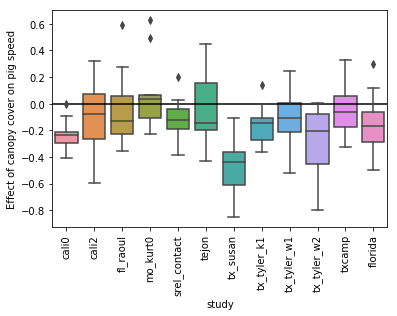

In [44]:
cc = modparams[1][modparams[1].coef.isin(['canopycover_loc'])]
cc
ax = sns.boxplot(x="study", y="value", data=cc)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.hlines(0, *ax.get_xlim())
ax.set_ylabel("Effect of canopy cover on pig speed")
plt.savefig("../docs/presentations/images/canopycover_pop.pdf", bbox_inches="tight")

Text(0,0.5,'Average effect canopy cover on pig direction')

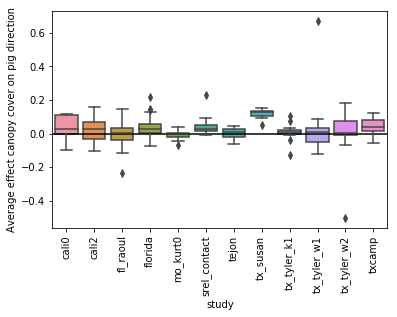

In [136]:
b = modparams[1]
cc_grad = b[b.coef.str.find("canopycover_grad") != -1].groupby(['study', 'pigID']).value.mean().reset_index()
cc_grad

ax = sns.boxplot(x="study", y="value", data=cc_grad)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.hlines(0, *ax.get_xlim())
ax.set_ylabel("Average effect canopy cover on pig direction")
#plt.savefig("../docs/presentations/images/canopycover_grad.pdf", bbox_inches="tight")

Text(0,0.5,'Effect of elevation on pig speed')

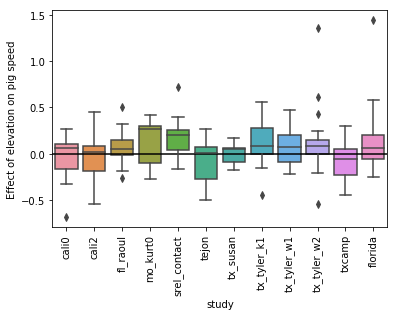

In [103]:
cc = modparams[1][modparams[1].coef.isin([''])]
ax = sns.boxplot(x="study", y="value", data=cc)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.hlines(0, *ax.get_xlim())
ax.set_ylabel("Effect of elevation on pig speed")
#plt.savefig("../docs/presentations/images/canopycover_pop.pdf", bbox_inches="tight")

In [48]:
modparams[1].coef.unique()

array(['fruit_and_nuts_loc', 'ndvi_loc', 'masting_loc', 'elevation_loc',
       'canopycover_loc', 'developed_grad', 'base_hour_morning',
       'base_hour_midday', 'base_hour_evening', 'ndvi_grad_morning',
       'ndvi_grad_midday', 'ndvi_grad_evening', 'masting_grad_morning',
       'masting_grad_midday', 'masting_grad_evening',
       'elevation_grad_morning', 'elevation_grad_midday',
       'elevation_grad_evening', 'canopycover_grad_morning',
       'canopycover_grad_midday', 'canopycover_grad_evening',
       'water_grad_morning', 'water_grad_midday', 'water_grad_evening',
       'crw_morning', 'crw_midday', 'crw_evening',
       'fruit_and_nutsdists_grad_morning',
       'fruit_and_nutsdists_grad_midday',
       'fruit_and_nutsdists_grad_evening', 'crw:fruit_and_nuts_loc',
       'crw:grasses_loc', 'grasses_loc', 'grassesdists_grad_morning',
       'grassesdists_grad_midday', 'grassesdists_grad_evening',
       'crw:other_loc', 'crw:oilseed_loc', 'crw:cereals_loc',
       'cerea

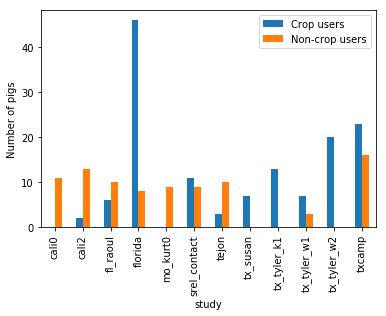

In [27]:
# Join crop user information and other pig attributes
joindt = []
for modp in modparams:
    
    moddt = modp.pivot_table(values='value', index=['pigID', 'study'], columns='coef').fillna(0)
    cusers = moddt.reset_index().set_index("pigID").join(cropuser.set_index(["pigID"])).join(pigatt.set_index("pigID"))
    joindt.append(cusers)

# Show summary of crop users
bplot = cusers.groupby("study").agg({"cropuser" : {'Crop users': lambda x: np.sum(x == True), 
                                           'Non-crop users' : lambda x: np.sum(x != True)} })
bplot.columns = bplot.columns.levels[1]
ax = bplot.plot.bar()
ax.set_ylabel("Number of pigs")
plt.savefig("../docs/presentations/images/cropusers.pdf", bbox_inches="tight")

## Step 1: Does the use of non-crop resources differ between crop and non-crop users?

Running a random forest classifier to identify whether there is any evidence that crop users and non-crop users use non-crop resources
differently.  Also examining the which variables determine how the crop-using and non-crop using pigs are grouping.

In [120]:
studynames = modparams[1].study.unique()
rfresults = {}

for study in studynames:
    
    rfresults[study] = []
    
    for model in joindt:
        
        studydt = model[model.study == study]
        rf = ensemble.RandomForestClassifier(n_estimators=800, min_samples_split=2, oob_score=True, n_jobs=3)
        
        y = studydt.cropuser.astype(np.int)
        
        if len(np.unique(y)) == 2:
            
            X = studydt.reset_index().set_index(['pigID', 'cropuser', 'study'])
            
            Xnoncrop = X.loc[:, ~X.columns.str.contains("|".join(ctypes))]
            Xnoncrop = Xnoncrop.assign(sex2=pd.get_dummies(Xnoncrop.sex).M.values)
            Xnoncrop = Xnoncrop.drop(columns="sex")
            
            # TODO: Break individuals into daily and seasonal levels? 
            
            # Fit a random forest classifier to each study
            vnames = Xnoncrop.columns
            rffit = rf.fit(Xnoncrop.values, y)
            rfresults[study].append((rffit, vnames, y))
            
            

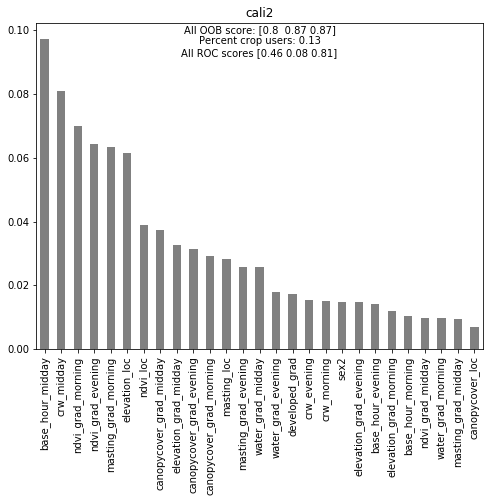

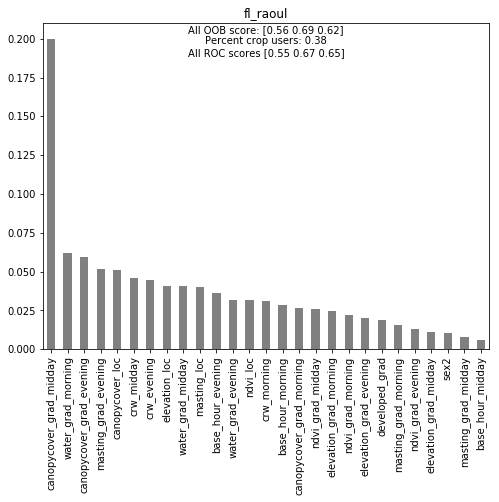

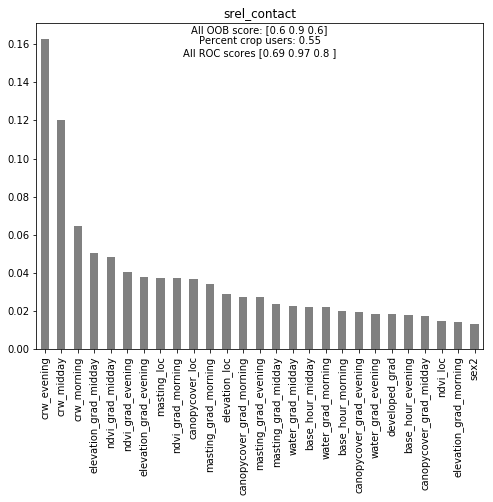

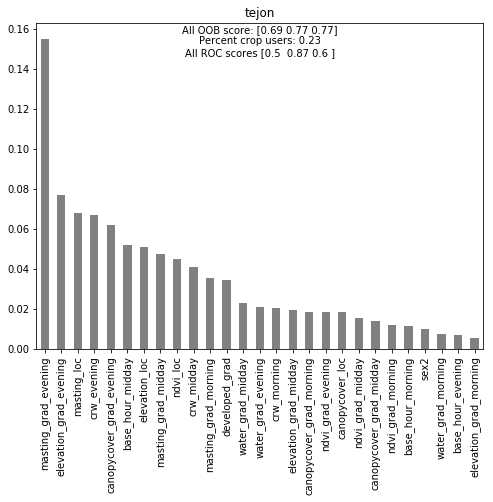

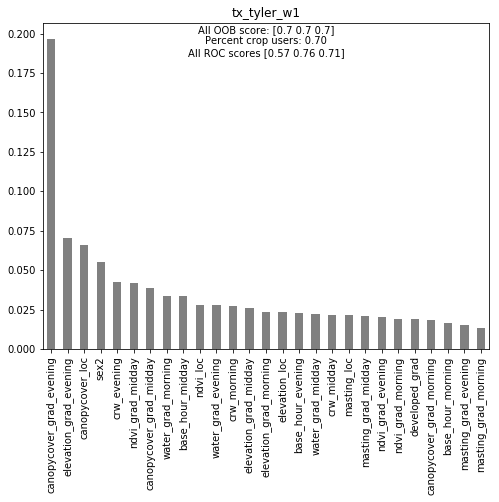

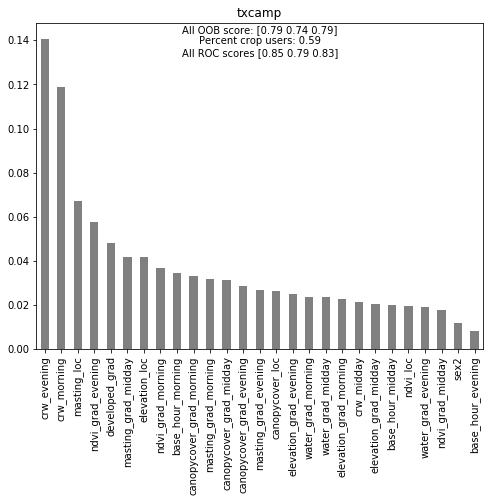

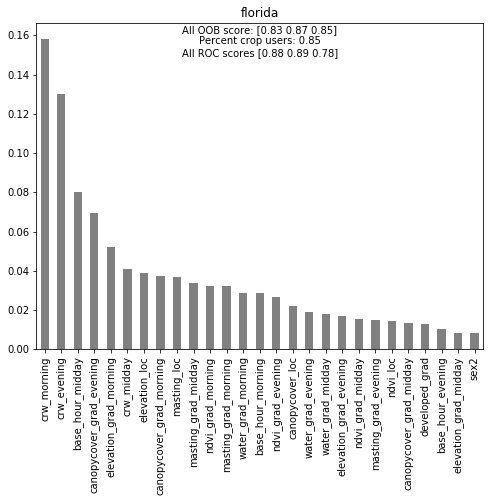

In [121]:
from sklearn.metrics import roc_auc_score

toptwo = []
for study in rfresults.keys():
    
    oob_scores = [est.oob_score_ for est, vnames, y in rfresults[study]]
    roc_scores = [roc_auc_score(y, est.oob_decision_function_[:, 1]) for est, vnames, y in rfresults[study]]
    
    if len(oob_scores) > 0:
        
        ind = np.argmax(oob_scores)
        est, vnames, y = rfresults[study][1]
        
        # ROC curve characteristics
        
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        imp = pd.Series(est.feature_importances_, index=vnames).sort_values(ascending=False)
        imp = pd.DataFrame(imp).assign(study=study).reset_index(drop=False)
        toptwo.append(imp.loc[:1])
        pd.Series(est.feature_importances_, index=vnames).sort_values(ascending=False).plot(kind="bar", ax=ax, color="grey")
        ax.tick_params(labelsize=10)
        ax.set_title(study)
        ax.text(0.5, 0.9, "All OOB score: {0}\nPercent crop users: {1:.2f}\nAll ROC scores {2}".format(np.round(oob_scores, decimals=2), np.sum(y == 1) / len(y), np.round(roc_scores, decimals=2)), ha="center", transform=ax.transAxes)
    

In [124]:
a

,index,value,study
0,base_hour_midday,0.097242,cali2
1,crw_midday,0.080879,cali2
0,canopycover_grad_midday,0.200089,fl_raoul
1,water_grad_morning,0.062341,fl_raoul
0,crw_evening,0.162862,srel_contact
1,crw_midday,0.120340,srel_contact
0,masting_grad_evening,0.155175,tejon
1,elevation_grad_evening,0.077272,tejon
0,canopycover_grad_evening,0.196735,tx_tyler_w1
1,elevation_grad_evening,0.070740,tx_tyler_w1


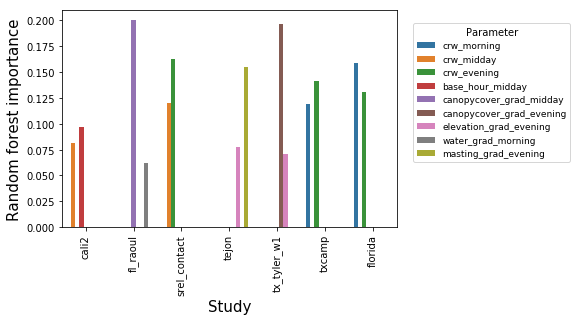

In [127]:
a = pd.concat(toptwo).rename(columns={0:'value'})
hue_order = ('crw_morning', 'crw_midday', 'crw_evening', 'base_hour_midday', 
             'canopycover_grad_midday', 'canopycover_grad_evening', 
             'elevation_grad_evening', "water_grad_morning", "masting_grad_evening")
ax = sns.barplot(x="study", y="value", hue="index", data=a, hue_order=hue_order)
ax.legend(loc=(1.05, 0.3), title="Parameter", prop={'size' : 9})
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel("Random forest importance", size=15)
ax.set_xlabel("Study", size=15)
plt.savefig("../docs/presentations/images/rf_results.pdf", bbox_inches="tight")

**Some conclusions**: Generally, there seems to be some signal to separate crop-users and non-crop users.  Particularly when you incorporate daily variation in behavior. One general attribute that seems to distinguish crop and non-crop users is their turning angle, essentially and how this varies with time of day. From exploratory plots, I the crop-users to to show increased directional movement (smaller turning angles) at certain points of the day, presumably as they are heading off to forage near crop fields.  This is no observed as frequently in non-crop using pigs.

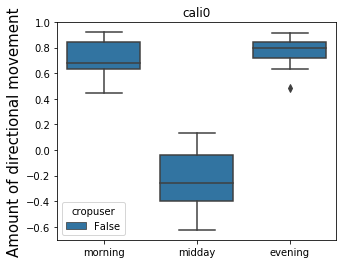

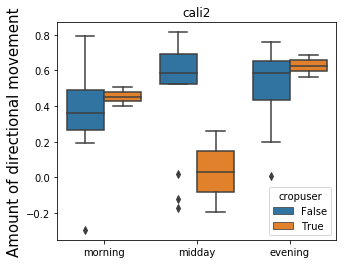

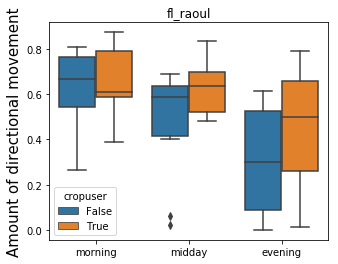

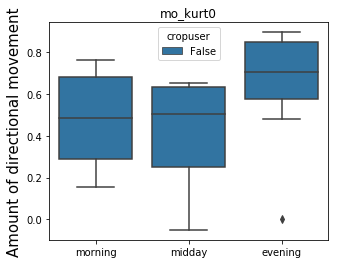

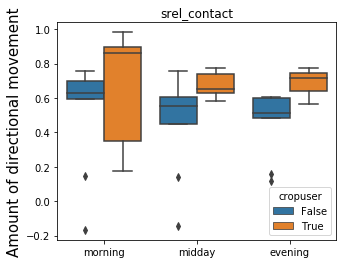

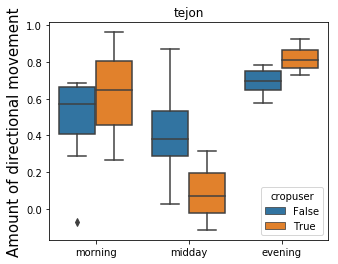

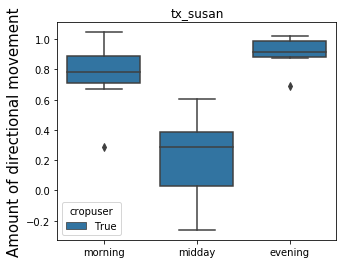

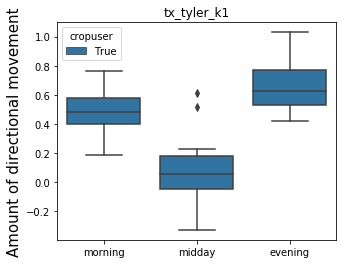

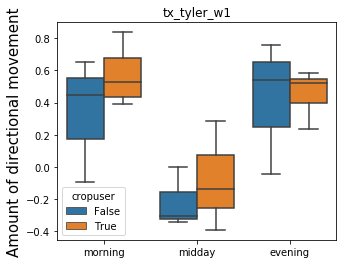

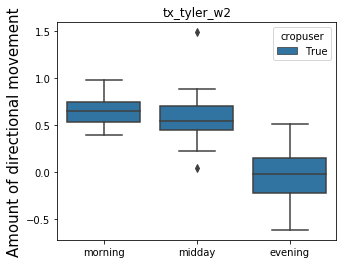

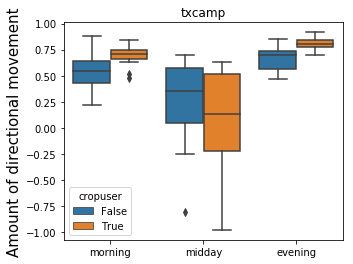

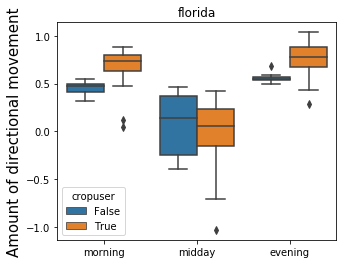

In [128]:
for study in studynames:
    
    fig, ax = plt.subplots(1, 1, figsize=(5, 4))
    studydt = joindt[1][joindt[1].study == study].reset_index()
    a = studydt[['crw_morning', 'crw_evening', 'crw_midday', 'cropuser', 'pigID']].melt(id_vars=['pigID', 'cropuser'], var_name="coef")
    
    a.loc[a.coef == "crw_morning", "coef"] = "morning"
    a.loc[a.coef == "crw_evening", "coef"] = "evening"
    a.loc[a.coef == "crw_midday", "coef"] = "midday"
    
    ax = sns.boxplot(x='coef', y='value', hue="cropuser", data=a, 
                                 order=['morning', 'midday', 'evening'])
    ax.set_title(study)
    ax.set_ylabel("Amount of directional movement", size=15)
    ax.set_xlabel("")
    
    if study =="florida" or study == "txcamp" or study == "srel_contact":
        plt.savefig("../docs/presentations/images/{0}_crw.pdf".format(study), bbox_inches="tight")

## Step 2:  Focusing on differences between crop-users

**Do crop-users fall out into different behavioral regimes?**

Using a Gaussian mixture model to understand whether there is any evidence that crop users should be grouped.

The Gaussian mixture model conceptually (I think...) separates the data is a very similar way as a PCA. The 

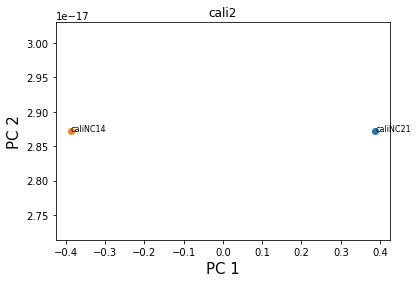

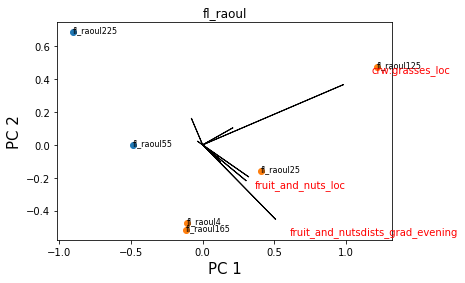

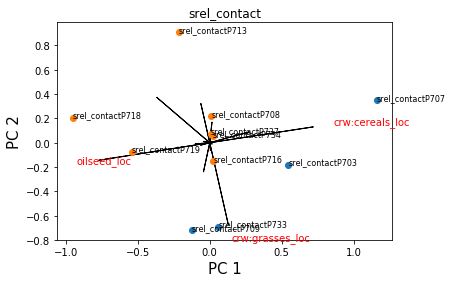

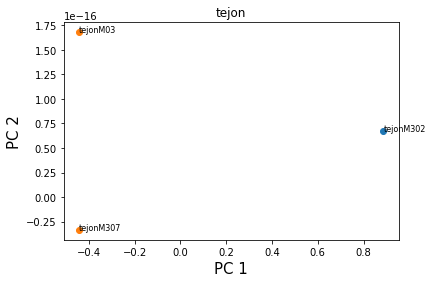

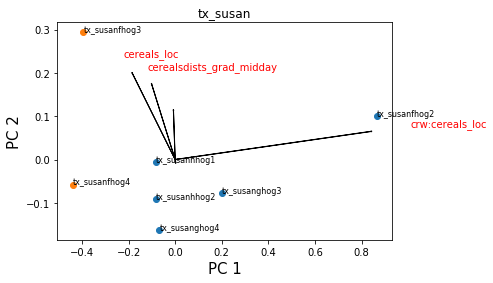

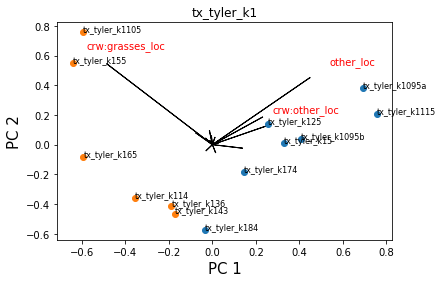

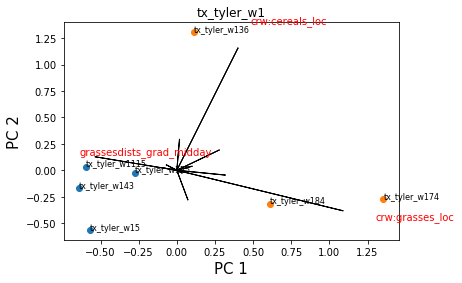

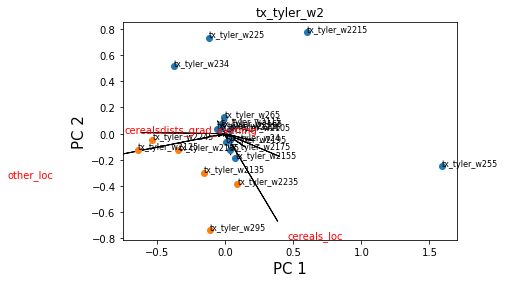

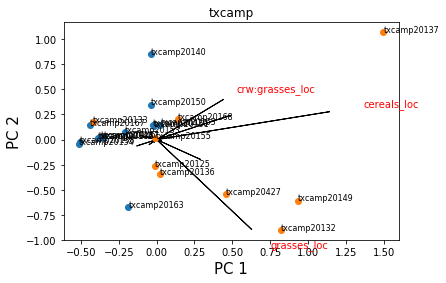

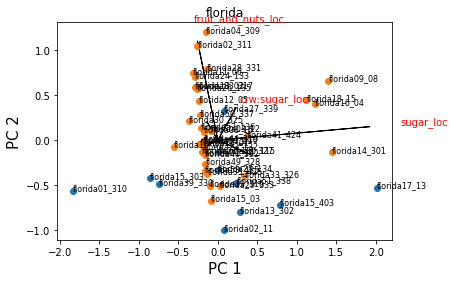

In [184]:
mix_res = {}
Xy_res = {}
for study in studynames:
    
    # Just extract the daily object
    studydt = joindt[1][joindt[1].study == study]
    
    # Extract crop columns
    studydt = studydt.reset_index().set_index(['pigID', 'study', 'sex', 'cropuser'])
    Xcrop = studydt.loc[:, studydt.columns.str.contains("|".join(ctypes))]
    
    # Only consider crops columns that actually have values
    Xcrop = Xcrop.loc[:, Xcrop.std(axis=0) != 0].reset_index()
    X = Xcrop[Xcrop.cropuser == True].set_index(['pigID', 'study', 'cropuser', 'sex'])
    
    # A few huge outliers that I need to take care of
    X[X > 2] = 1
    X[X < -2] = -1
    
    # Fit a range of Gaussian mixture models
    if len(X) > 0:
        
        if len(X) > 2:
            num_comp = range(1, 4) # Three groups
        else:
            num_comp = range(1, 3) # Only 2 groups 
        
        # PCA the data
        Xpca = X.values #PCA().fit_transform(X.values)
        pca = PCA()
        pcafit = pca.fit(X.values)
        Xpca2 = PCA().fit_transform(X.values)
        
        # 50 random starts to get the best initialization. The starting values matter!
        estimators = [mixture.GaussianMixture(n_components=nc, n_init=50, max_iter=1000) for nc in num_comp]
        fits = [est.fit(Xpca) for est in estimators]
        bics = [fit.bic(Xpca) for fit in fits]
        labels = [fit.predict(Xpca) for fit in fits]
        mix_res[study] = (fits, bics, labels)
        Xy_res[study] = (X, labels)
        
        # Plot the labels in PCA space
        fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        ax.plot(Xpca2[labels[1] == 1, 0], Xpca2[labels[1] == 1, 1], 'o')
        ax.plot(Xpca2[labels[1] == 0, 0], Xpca2[labels[1] == 0, 1], 'o')
        
        for i in range(len(X)):
            ax.text(Xpca2[i, 0], Xpca2[i, 1], X.reset_index().pigID[i], size=8)
            
        ax.set_title(study)
        ax.set_ylabel("PC 2", size=15)
        ax.set_xlabel("PC 1", size=15)
        
        if study in ["srel_contact", "tx_tyler_k1"]:
            plt.savefig("../docs/presentations/images/{0}_groups.pdf".format(study), bbox_inches="tight")
        
        if not (study in ["tejon", "cali2"]):
            xs = Xpca2[:, 0]
            ys = Xpca2[:, 1]

            xvector = pcafit.components_[0]
            yvector = pcafit.components_[1]
            grad = np.hstack((xvector[:, np.newaxis], yvector[:, np.newaxis]))
            gradsize = np.diag(np.dot(grad, grad.T))
            maxinds = np.argsort(gradsize)[-3:]

            for i in range(len(xvector)):
                # arrows project features (ie columns from csv) as vectors onto PC axes
                ax.arrow(0, 0, xvector[i]*max(xs), yvector[i]*max(ys),
                                    width=0.0005, head_width=0.0025)
                
                if i in list(maxinds):
                    ax.text(xvector[i]*max(xs)*1.2, yvector[i]*max(ys)*1.2,
                         list(X.columns.values)[i], color='r')
        
        if study in ["srel_contact", "tx_tyler_k1"]:
           plt.savefig("../docs/presentations/images/{0}_groups_vector.pdf".format(study), bbox_inches="tight")

In [181]:
grad

array([ 0.26216716,  0.80602121,  0.24778205,  0.41697152, -0.06362369,
        0.10074008, -0.02780513,  0.04390854,  0.17157906, -0.2821869 ,
        0.5340866 , -0.31644247, -0.65920467,  0.23253708, -0.14739838,
        0.03042544,  0.03453774,  0.15005692])

In [178]:
np.argsort?

In [177]:
grad = np.hstack((xvector[:, np.newaxis], yvector[:, np.newaxis]))
np.diag(np.dot(grad, grad.T))

array([5.60336718e-03, 7.97484555e-07, 6.63945107e-06, 3.40023538e-02,
       5.75086944e-03, 1.02045314e-01, 8.56954553e-01, 1.34004339e-03,
       1.18429248e-03, 7.90921343e-04, 6.16115817e-02, 9.62483784e-04,
       8.73105719e-04, 1.42671001e-03, 9.26196463e-01, 9.52612694e-05,
       2.69940846e-04, 8.85302560e-04])

In [163]:
pcafit.components_[0]

array([-5.93202472e-02,  7.07684285e-04,  2.04194716e-03, -6.85240910e-02,
       -7.14208987e-02,  1.13858843e-01, -1.27666647e-01,  1.86024066e-02,
        3.42124351e-02, -1.49317862e-02,  2.08045624e-01,  1.05026955e-02,
       -1.91689658e-02, -2.49219452e-02,  9.54233129e-01, -1.66573026e-03,
        1.61197138e-02, -2.17373014e-02])

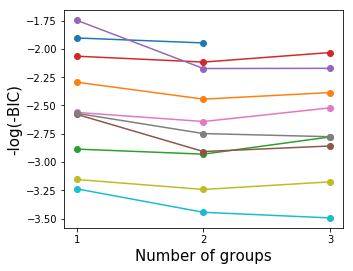

In [148]:
kb = {key : bics for key, (fits, bics, labels) in mix_res.items()}

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
for study, bics in kb.items():
    
    x = range(1, len(bics) + 1)
    ax.plot(x, -1*np.log10(-1*np.array(bics)), '-o')

ax.set_xticks(np.arange(1, 4))
ax.set_xlabel("Number of groups", size=15)
ax.set_ylabel("-log(-BIC)", size=15)

plt.savefig("../docs/presentations/images/bic.pdf", bbox_inches="tight")

In [454]:
{key : np.argmin(bics) + 1 for key, (fits, bics, labels) in mix_res.items()}

{'cali2': 2,
 'fl_raoul': 2,
 'florida': 3,
 'srel_contact': 2,
 'tejon': 2,
 'tx_susan': 2,
 'tx_tyler_k1': 2,
 'tx_tyler_w1': 2,
 'tx_tyler_w2': 3,
 'txcamp': 2}

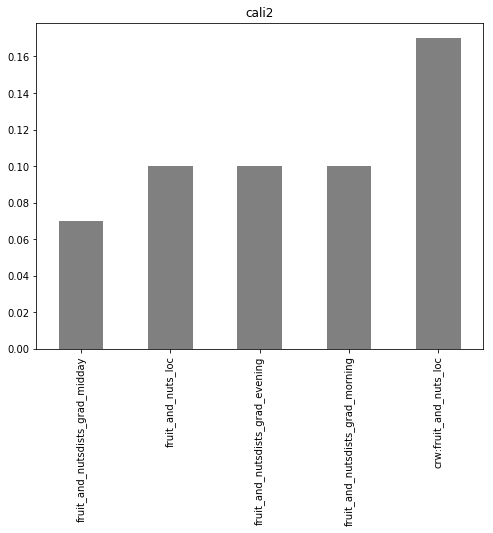

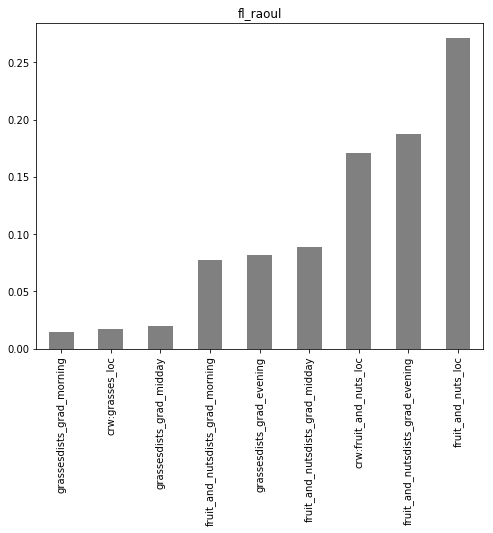

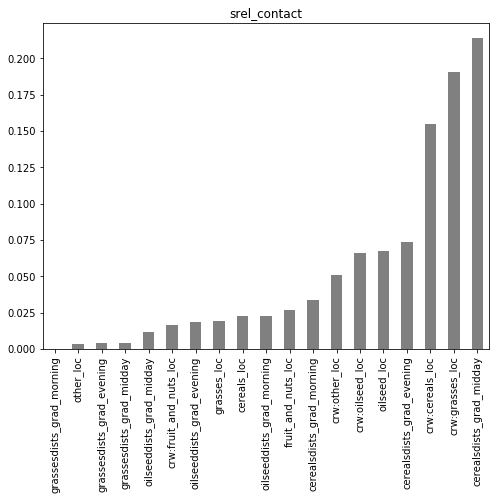

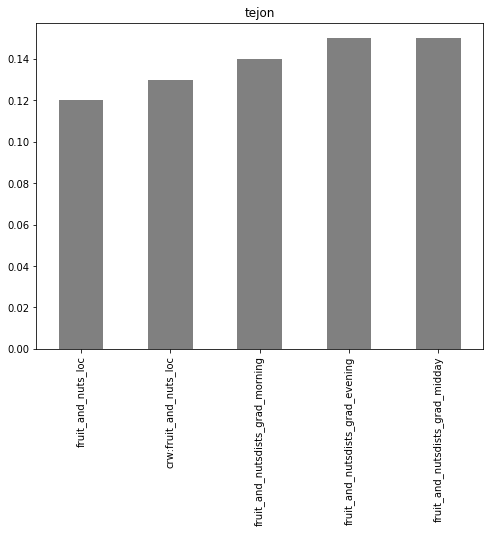

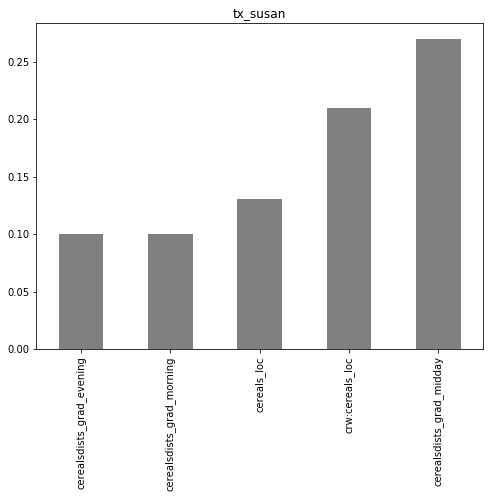

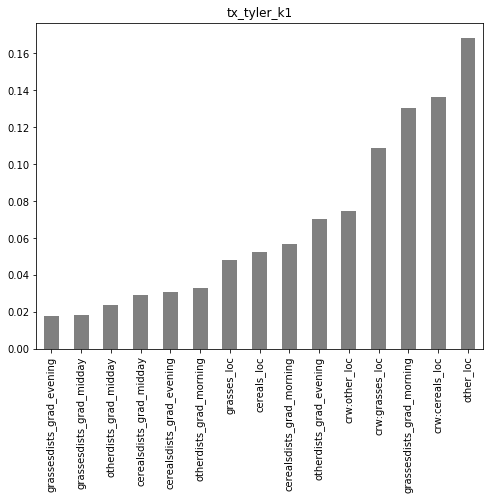

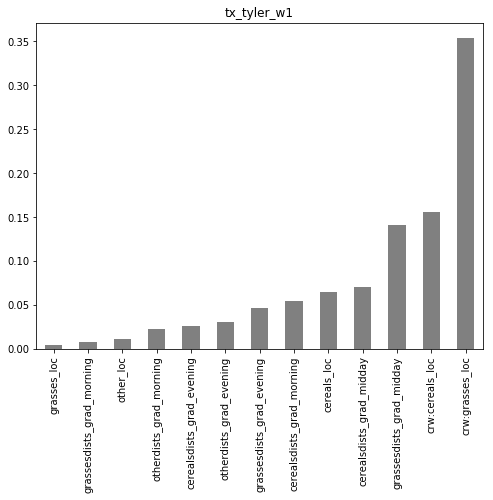

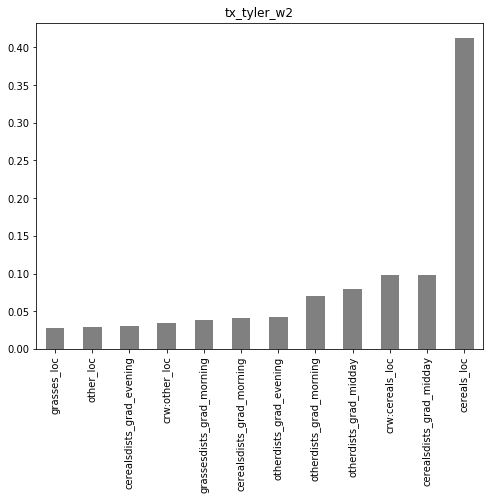

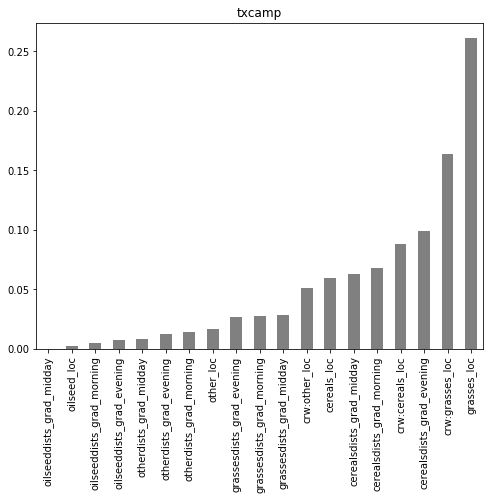

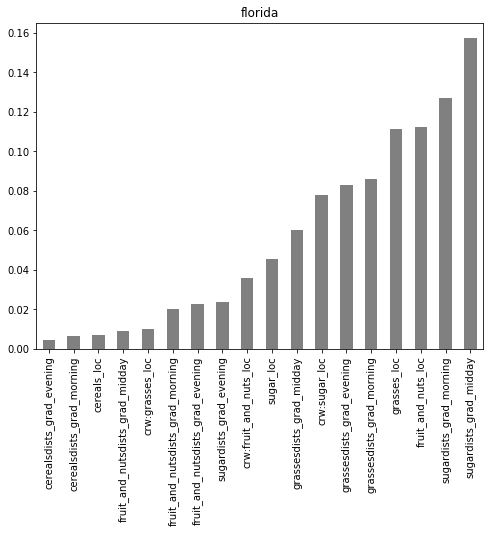

In [455]:

for study in Xy_res.keys():
    
    X, y = Xy_res[study]
    
    rf = ensemble.RandomForestClassifier(n_estimators=100, min_samples_split=2, oob_score=True, n_jobs=3)
    est = rf.fit(X.values, y[1])
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    pd.Series(est.feature_importances_, index=X.columns).sort_values().plot(kind="bar", ax=ax, color="grey")
    ax.tick_params(labelsize=10)
    ax.set_title(study)

In [154]:
components = {}
for study in Xy_res.keys():
    
    X, y = Xy_res[study]
    
    pcafit = PCA().fit(X.values)
    components[study] = pd.DataFrame(pcafit.components_, columns=X.columns).T

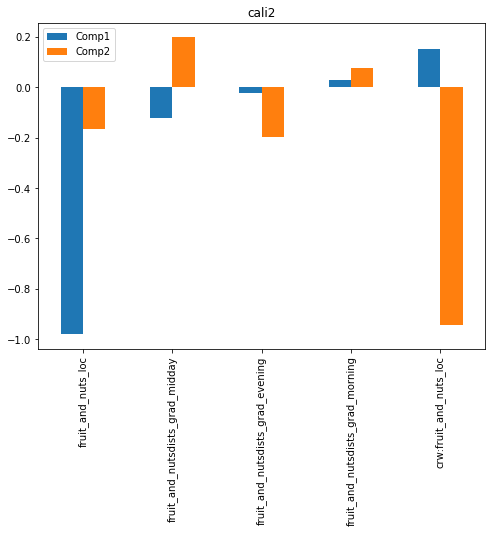

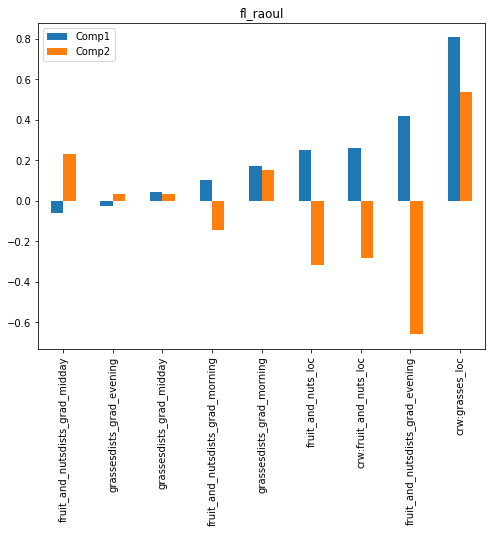

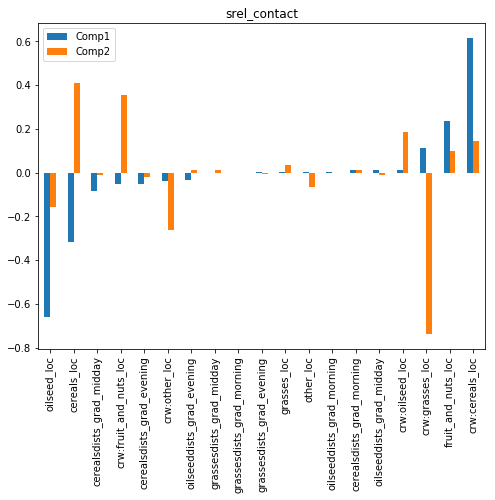

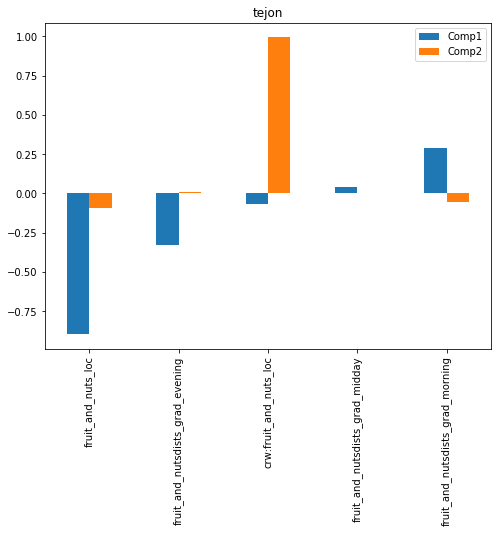

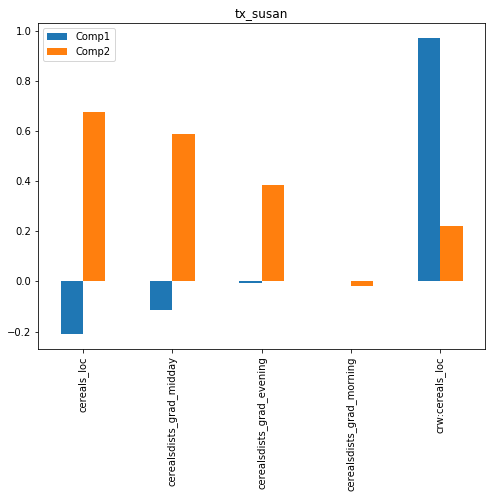

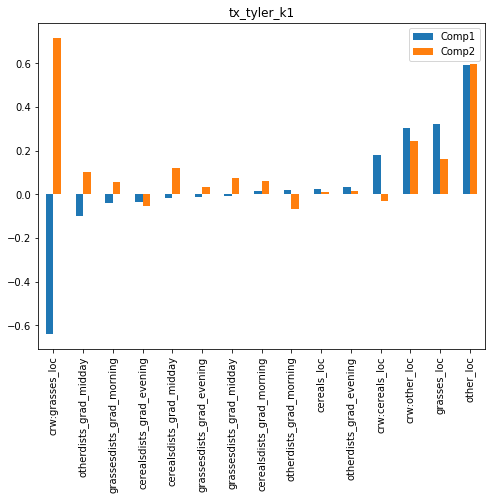

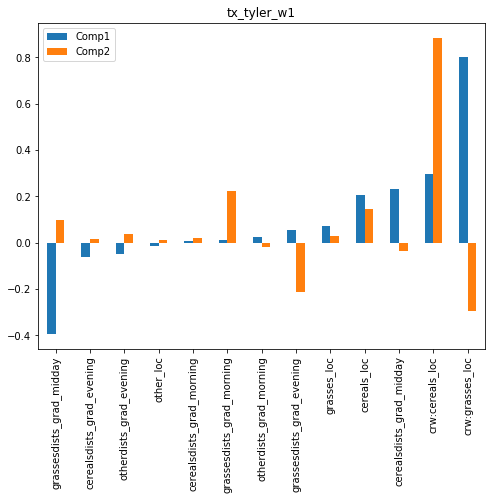

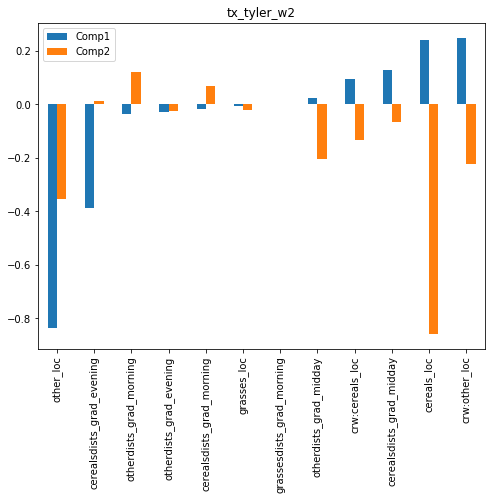

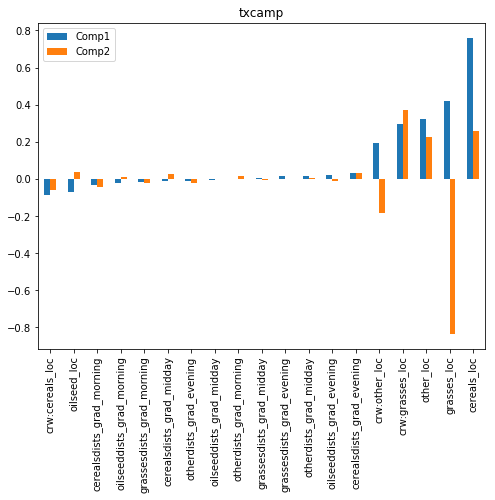

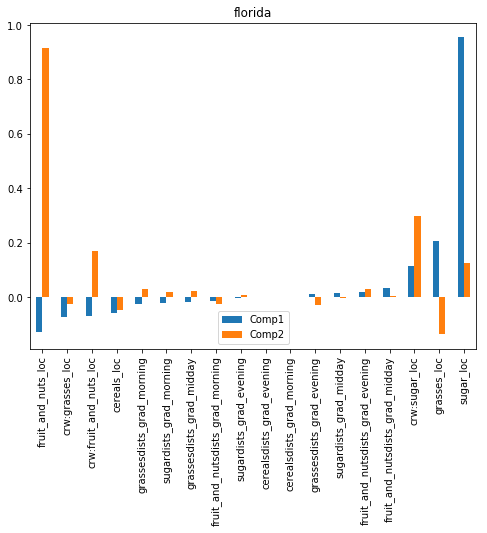

In [457]:
for study in components.keys():
    
    comps = components[study][[0, 1]].sort_values(0)
    comps.columns = ['Comp1', 'Comp2']
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    xspec = np.linspace(0, 1, num=len(comps))
    
    comps.plot(kind="bar", ax=ax)
    ax.set_title(study)

**Some conclusions**

The data (in combinations with a Gaussian Mixture model) strongly suggest that crop using pigs should be broken into multiple groups and representation of crop users in PCA space shows that, in general, and a linear classifier could distinguish between the PCA transformed data.  

Examining the first two components of the PCA gives us a sense of why crop using pigs are grouping differently.

1. In almost all sites, the majority of variation is being described by pig behavior when in crops. In other words, the speed and turning angle (i.e. directional persistence) of pigs in crops varies greatly by between crop using pigs.
2. Note that I am not standardizing the coefficients before running a PCA. These are parameters are all on the same scale (unit change in standardized predictor).  Is there an argument for standardizing the coefficients? I don't think so since all parameters are already unitless...

---

Taken together, let's reconsider our questions

1. Do crop-using pigs use non-crop resources differently than non-crop using pigs?
    - After accounting for crop-use, the primary driver of differences between crop and non-crop using pigs is directional movement patterns and speed of movement, rather than differences in non-crop resource use.  This is independent of parameter scale.
    - This could be biased by the fact more crop using pigs are male...and tend to have increased directional movement (larger home ranges)
    
2. Are there different groups of crop-using pigs?
    - The data suggest that it is not statistically unreasonable to break pigs up into different groups of crop use (2-3 groups)
    - Why crop using pigs differ varies by study site, but a PCA analysis shows that much of the variation in the groups is described by how pigs move within crops: speed and direction of movement within crops. 
    
---

**Next steps**

I am not really doing any sort of cross population comparison and I am not sure I really can given the data between populations are so different. 

General comparisons could be done by using the generic `crop_loc` variable for each study rather than the specific crop types. This would make it easier to pool across studies.  

The season problem is still quite real.  Temperature and precipitation offer a potential solution, but given the non-linear nature of these responses and the fact that not all pigs experience the same precipitation and temperature regimes, I don't know if these really do much better than season. Season is easier to interpret too, particularly with respect to temperature and precipitation plots. 

### Use the random forest OOB approach to generate a random forest proximity matrix

See https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#unsup

1. Draw the same number of samples as you have in your training dataset
2. For each predictor, draw the new predictor from the possible distributions of the old predictor

In [197]:
np.random.random_sample?

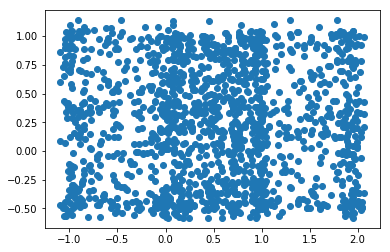

In [183]:
sampinds1 = np.random.randint(0, X.shape[0], size=X.shape[0])
sampinds2 = np.random.randint(0, X.shape[0], size=X.shape[0])
newX = np.hstack((X[sampinds1, 0][:, np.newaxis], X[sampinds2, 1][:, np.newaxis]))

fullX = np.vstack((X, newX))
fully = np.array([1]*X.shape[0] + [2]*X.shape[0])

plt.plot(newX[:, 0], newX[:, 1], 'o')

In [220]:
from sklearn.ensemble import RandomForestClassifier

rcf = RandomForestClassifier(n_estimators=500, max_depth=4, oob_score=True)
rcffit = rcf.fit(fullX, fully)

In [221]:
rcffit.oob_score_

0.6603333333333333

In [ ]:
?RandomForestClassifier

In [222]:
# Count how many times each pair is in the same node
res = [csr_matrix(pd.get_dummies(est.apply(X)).values) for est in rcffit.estimators_]
ressqaured = [np.dot(x, x.T).toarray() for x in res]

In [223]:
sim = np.array(ressqaured).sum(axis=0) / 500

(array([   324.,   4575.,  15971.,  46363.,  76409.,  84574.,  64032.,
         61872., 180933.,  27447.]),
 array([0.186, 0.266, 0.346, 0.426, 0.506, 0.586, 0.666, 0.746, 0.826,
        0.906, 0.986]),
 <a list of 10 Patch objects>)

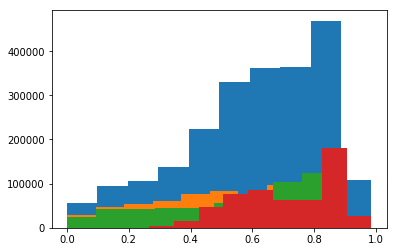

In [224]:
plt.hist(1 - sim.ravel())

ind = y == 1
clust1 = sim[ind, :][:, ind]
clust2 = sim[~ind, :][:, ~ind]
clust3 = sim[ind, :][:, ~ind]
plt.hist(1 - clust1.ravel())
plt.hist(1 - clust2.ravel())
plt.hist(1 - clust3.ravel())

In [237]:
# Project X into RF space
from sklearn.cluster import DBSCAN
kmod = DBSCAN(metric="precomputed")
dbfit = kmod.fit(1 - sim)

In [242]:
dbfit.metric

(array([171106.,  51934.,  19855.,   7356.,   8802.,   9093.,   5201.,
          2806.,   3072.,   2400.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

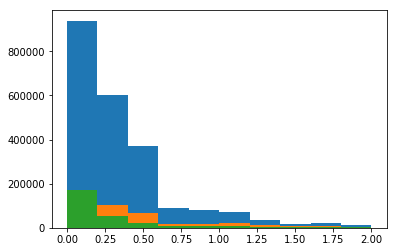

In [138]:
clust1 = sim[ind, :][:, ind]
clust2 = sim[~ind, :][:, ~ind]
plt.hist(sim.ravel())
plt.hist(clust1[np.triu_indices_from(clust1)])
plt.hist(clust2[np.triu_indices_from(clust2)])

In [129]:
clust2[np.triu_indices_from(clust2)]

array([1.        , 0.        , 0.06666667, ..., 1.        , 0.        ,
       1.        ])

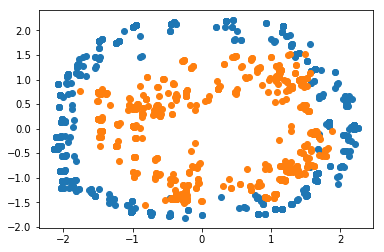

In [75]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
Xpca = pca.fit(Xtrans.toarray()).transform(Xtrans.toarray())

ind = noisy_circles[1] == 1
plt.plot(Xpca[ind, 0], Xpca[ind, 1], 'o')
plt.plot(Xpca[~ind, 0], Xpca[~ind, 1], 'o')